In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat
import os
import sys

In [2]:
# path to functions
sys.path.append(r"/home/illich/SeriesDistance/SeriesDistance Python NEU/functions Python NEU/")

# import functions
from f_smooth_DP import f_smooth_DP
from f_ReplaceEqualNeighbours import f_ReplaceEqualNeighbours
from f_FindSplitPoints import f_FindSplitPoints
from f_PlotInput import f_plot_input
from f_CoarseGraining_SD_Continuous import f_coarse_graining_continuous
from f_PlotConnectedSeries import f_PlotConnectedSeries
from f_PlotSDErrors_OnePanel import f_PlotSDErrors_OnePanel
from f_CoarseGraining_Event import f_CoarseGraining_Event
from f_SegStats import f_SegStats
from f_plot_ObjectiveFunction_CoarsGrainStps import f_plot_ObjectiveFunction_CoarsGrainStps
from f_SD import f_sd

orginal obs: var: 69.17573980287398, # extremes: 1989, diff(obs)=3408.5409999999997
orginal sim: var: 52.864675367601265, # extremes: 500, diff(sim)=2680.4161
smoothed obs: var: 69.04460552400174, # extremes: 246, diff(obs)=2957.6129999999994
smoothed sim: var: 52.864675367601265, # extremes: 500, diff(sim)=2680.4161


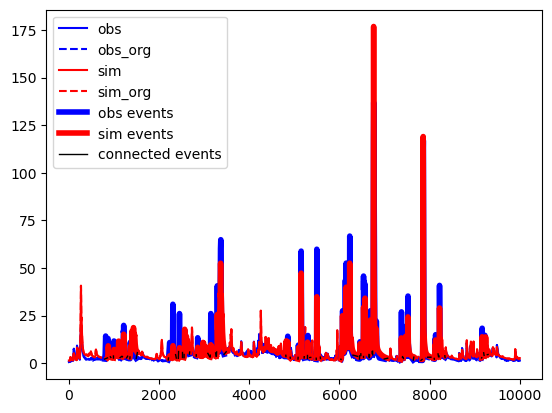

event 1 of 26
check 3
num_red: 0


check 4
num_red: 0
cons {'x_match_obs_global': [np.float64(793.0), np.float64(814.0)], 'y_match_obs': [np.float64(2.226153846153846), np.float64(13.352)], 'x_match_sim_global': [np.float64(856.0), np.float64(871.0)], 'y_match_sim': [np.float64(2.8197), np.float64(8.9356)]}
cons len 4


event 2 of 26
check 3
num_red: 3


check type
segs_obs: [{'starttime_global': np.int64(988), 'starttime_local': 0, 'endtime_global': np.int64(1032), 'endtime_local': 44, 'length': 44, 'rel_length': 0.2972972972972973, 'sum_dQ': np.float64(4.667999999999999), 'rel_dQ': np.float64(0.444823593405823), 'relevance': np.float64(0.372237227565416)}, {'starttime_global': np.int64(999), 'starttime_local': 11, 'endtime_global': np.int64(1045), 'endtime_local': 57, 'length': 46, 'rel_length': 0.3108108108108108, 'sum_dQ': np.float64(-3.82076923076923), 'rel_dQ': np.float64(0.29783286043283086), 'relevance': np.float64(0.301260715849889)}, {'starttime_global': np.int64(1022), 'star

AttributeError: 'list' object has no attribute 'starttime_global'

In [3]:
# ======================================================================
#                 Series Distance Analysis (Event Mode)
# ======================================================================
# last modification 16.08.2016

# This program (development release) determines SeriesDistance (SD) error distributions
# between 'events' in observed (obs) and simulated (sim) discharge time series. Using
# sim and obs, indices of event start and end points and information on valid pairs
# of events, the program determines separate error distributions for:
#  - rising limbs within events (2d error distribution of time- and magnitude errors)
#  - falling limbs within events (2d error distribution of time- and magnitude errors)
#  - no-event times (low-flow, 1d error distribution of magnitude errors)

# Further information:
# Seibert, S. P., Ehret, U., and Zehe, E., 2016: Disentangling timing and amplitude errors in streamflow simulations, Hydrol. Earth Syst. Sci.
# Ehret, U., Zehe, E., 2011. Series distance - An intuitive metric to quantify hydrograph similarity in terms of occurrence, amplitude and timing of hydrological events. Hydrol. Earth Syst. Sci. 15, 877–896. doi:10.5194/hess-15-877-2011

# Dependencies
# All required functions are stored in folder \functions

# Input (ascii format)
#  - obs: [n,1] matrix with equidistant and NaN-free time series of observed discharge data.
#  - sim: [n,1] matrix with equidistant and NaN-free time series of simulated discharge data.
#  - obs_events: [m,2] matrix with start and end times of events in 'obs'. [m,1]=start, [m,2]=end.
#  - sim_events: [m,2] matrix with start and end times of events in 'sim'. [m,1]=start, [m,2]=end.
#  - obs_sim_pairing: [m,2] matrix with events in 'obs_events' and 'sim_events' that belong together.

# Parameters are explained and specified in the parameter block

# Output (all stored within a single binary file .mat)
#  - obs:               observed discharge (smoothed)
#  - sim:               simulated discharge
#  - segs_obs_opt_all:  struct that contains the coarse-grained segments of obs
#  - segs_sim_opt_all:  struct that contains all coarse-grained segments of sim
#  - connectors:        struct with SD connectors for periods of low flow and events
#  - e_sd_q_rise:       SD magnitude errors for rising limbs
#  - e_sd_t_rise:       SD timing errors for rising limbs
#  - e_sd_q_fall:       SD magnitude errors for falling limbs
#  - e_sd_t_fall:       SD timing errors for falling limbs
#  - e_sd_lowFlow:      1D errors for low-flow
#  - error_model:       'relative' or 'standard'
#  - seg_raw_statistics: statistics of the original time series e.g. number of peaks, troughs, duration of rising/ falling segments
#  - seg_opt_statistics: statistics of the coarse-grained time series e.g. number of peaks, troughs, duration of rising/ falling segments

# Specify paths and parameters, read inputs
# os.chdir('ADD_YOUR_PATH_HERE')  # set working directory

########################################################### mein Working Directory ###########################################################
os.chdir(r"/home/illich/SeriesDistance/")
########################################################### mein Working Directory ###########################################################

# Read input
obs = pd.read_csv('data/HOST_timeseries.csv', delimiter=';', usecols=[2], skiprows=1, nrows=10000).values.flatten()
sim = pd.read_csv('data/HOST_timeseries.csv', delimiter=';', usecols=[3], skiprows=1, nrows=10000).values.flatten()
obs_events = pd.read_csv('data/HOST_obs_events.csv', delimiter=';').values
sim_events = pd.read_csv('data/HOST_sim_events.csv', delimiter=';').values
obs_sim_pairing = pd.read_csv('data/HOST_event_pairing.csv', delimiter=';').values  # 1 row = 1 event pair. [n,1]=start time of obs event, [p,2]= start time of sim event. (optional)

# Output filename
outfile = './results/output.mat'

# Smoothing options
smooth_flag = True  # smooth both obs and sim (default=True)
nse_smooth_limit = 0.99  # specifies degree of smoothing according to NSE criterion (default=0.99)

# Specification of the magnitude error model
error_model = 'relative'  # 'relative' or 'standard'; (standard: (sim-obs), relative: [(sim-obs)/((sim + obs)/2)] (default='relative')

# Parametrization of the objective function
weight_nfc = 1/7  # weights number of re-assigned hydrological cases (default= 1/7)
weight_rds = 1/7  # weights the importance of the re-assigned segments (default=1/7)
weight_sdt = 5/7  # weights the SD timing error component (default=5/7)
weight_sdv = 0  # weights the SD magnitude error component (default=0)

# Set plot flags
pf_input = True  # plots smoothed and original input time series ('obs' and 'sim')
pf_CoarseGrainSteps = False  # plots intermediate coarse graining steps and progression of objective function (NOTE: 'true' leads to MANY plots)
pf_segs_cons_indivEvents = False  # plots each individual event with optimized segments and connectors in an own figure
pf_objective_functions = False  # plots the SD objective function for each event in an own figure
pf_segs_cons_entireSeries = True  # plots the entire time series with optimized segments and connectors in an individual figure
pf_errorDistributions = True  # SeriesDistance error distributions for rise, fall and low-flow

# Data manipulations and pre-processing
# allows to select a (1:to) subset of the provided time series, the remainder is ignored.
# to = 2000
# obs, sim, obs_events, sim_events, obs_sim_pairing = f_inputsubset(to, obs, sim, obs_events, sim_events, obs_sim_pairing)
# del to

# Smooth if required (default=True)
if smooth_flag:
    obs_org = obs.copy()
    sim_org = sim.copy()
    obs, sim = f_smooth_DP(obs, sim, nse_smooth_limit)

# Replace identical neighboring values to avoid problems with assignment of unique peaks and valleys
obs = f_ReplaceEqualNeighbours(obs)
sim = f_ReplaceEqualNeighbours(sim)

# Plot input data
if pf_input:
    f_plot_input(obs_org, obs, obs_events, sim_org, sim, sim_events, obs_sim_pairing, [])

# Cleanup
del smooth_flag, nse_smooth_limit, pf_input

# Initialize output arrays for both, coarse graining and SD
e_sd_t_rise = []  # error distribution for events, rise, time component
e_sd_q_rise = []  # error distribution for events, rise, magnitude component
e_sd_t_fall = []  # error distribution for events, fall, time component
e_sd_q_fall = []  # error distribution for events, fall, magnitude component
segs_obs_opt_all = []  # coarse-grained segments of 'obs'
segs_sim_opt_all = []  # coarse-grained segments of 'sim'
seg_raw_statistics = []  # segment statistics
seg_opt_statistics = []  # segment statistics
seg_event_id = []  # stores event ID for each segs_opt object
connectors = {'x_match_obs_global': [], 'y_match_obs': [], 'x_match_sim_global': [], 'y_match_sim': []}  # connectors between matching points in 'obs' and 'sim'

# Apply coarse-graining and SD method to each event
for ii in range(len(obs_sim_pairing)):
    # Fortschritt in der Kommandozeile ausgeben
    print(f'event {ii + 1} of {len(obs_sim_pairing)}')
    
    # Start- und Endpunkte des Ereignisses abrufen
    obs_eventindex = np.arange(obs_sim_pairing[ii, 0], obs_events[np.where(obs_events[:, 0] == obs_sim_pairing[ii, 0])[0][0], 1] + 1)
    sim_eventindex = np.arange(obs_sim_pairing[ii, 1], sim_events[np.where(sim_events[:, 0] == obs_sim_pairing[ii, 1])[0][0], 1] + 1)

    # Grobkörnigkeit anwenden: Bestimmt das optimale Aggregationsniveau jedes Ereignisses
    segs_obs_opt, segs_sim_opt, cons, connector_data, ObFuncVal, opt_step, CoarseGrain_segs, seg_raw_stats = \
        f_CoarseGraining_Event(obs, obs_eventindex, sim, sim_eventindex, weight_nfc, weight_rds, weight_sdt, weight_sdv, error_model, pf_CoarseGrainSteps)

    # Segmentstatistiken zusammenfassen (vor und nach der Grobkörnigkeit)
    seg_raw_statistics.append(seg_raw_stats)
    seg_opt_statistics.append([ii + 1] + f_SegStats(segs_obs_opt) + [(len(ObFuncVal) > 1), opt_step] + f_SegStats(segs_sim_opt))

    # Optimierte Segmentkombination für alle Ereignisse speichern
    segs_obs_opt_all.extend(segs_obs_opt)
    segs_sim_opt_all.extend(segs_sim_opt)
    
    # Entsprechende Ereignis-ID speichern (nur für das Plotten erforderlich)
    seg_event_id.extend([ii + 1] * len(segs_obs_opt))
    
    # Jedes einzelne Ereignis mit optimierten Segmenten und Verbindern in einer eigenen Abbildung plotten
    if pf_segs_cons_indivEvents:
        f_PlotConnectedSeries(obs, segs_obs_opt, sim, segs_sim_opt, cons)

    # Die Werte der Zielfunktion plotten
    if pf_objective_functions:
        f_plot_ObjectiveFunction_CoarsGrainStps(ObFuncVal, opt_step, f'event # {ii + 1}')

    # Bereinigung
    del cons, seg_raw_stats, ObFuncVal, opt_step, obs_eventindex, sim_eventindex
    
    # SD-Ergebnisse für das optimierte Generalisierungsniveau berechnen
    obs_fromto = np.arange(segs_obs_opt[0]['starttime_global'], segs_obs_opt[-1]['endtime_global'] + 1)
    sim_fromto = np.arange(segs_sim_opt[0]['starttime_global'], segs_sim_opt[-1]['endtime_global'] + 1)
    _, _, _, e_q_rise, e_t_rise, _, e_q_fall, e_t_fall, _, cons, _, _ = f_sd(obs[obs_fromto], segs_obs_opt, sim[sim_fromto], segs_sim_opt, error_model, 'true')

    # Gesamte SD-Fehlerverteilungen durch sukzessives Hinzufügen von Fehlern einzelner Ereignisse aufbauen
    e_sd_t_rise.extend(e_t_rise)
    e_sd_q_rise.extend(e_q_rise)
    e_sd_t_fall.extend(e_t_fall)
    e_sd_q_fall.extend(e_q_fall)
    
    # Einzelne Verbinder jedes einzelnen Ereignisses speichern
    print('cons', cons)
    print('cons len', len(cons))
    print('\n')

    # Original code der Übersetzung
    # if not connectors['x_match_obs_global']:
    #     connectors['x_match_obs_global'] = cons[0]['x_match_obs_global']
    #     connectors['y_match_obs'] = cons[0]['y_match_obs']
    #     connectors['x_match_sim_global'] = cons[0]['x_match_sim_global']
    #     connectors['y_match_sim'] = cons[0]['y_match_sim']
    # else:
    #     connectors['x_match_obs_global'].extend(cons[0]['x_match_obs_global'])
    #     connectors['y_match_obs'].extend(cons[0]['y_match_obs'])
    #     connectors['x_match_sim_global'].extend(cons[0]['x_match_sim_global'])
    #     connectors['y_match_sim'].extend(cons[0]['y_match_sim'])

    try:
        if not connectors['x_match_obs_global']:
            connectors['x_match_obs_global'] = cons[0]['x_match_obs_global']
            connectors['y_match_obs'] = cons[0]['y_match_obs']
            connectors['x_match_sim_global'] = cons[0]['x_match_sim_global']
            connectors['y_match_sim'] = cons[0]['y_match_sim']
        else:
            connectors['x_match_obs_global'].extend(cons[0]['x_match_obs_global'])
            connectors['y_match_obs'].extend(cons[0]['y_match_obs'])
            connectors['x_match_sim_global'].extend(cons[0]['x_match_sim_global'])
            connectors['y_match_sim'].extend(cons[0]['y_match_sim'])
    except:
        if not connectors['x_match_obs_global']:
            connectors['x_match_obs_global'] = cons['x_match_obs_global']
            connectors['y_match_obs'] = cons['y_match_obs']
            connectors['x_match_sim_global'] = cons['x_match_sim_global']
            connectors['y_match_sim'] = cons['y_match_sim']
        else:
            connectors['x_match_obs_global'].extend(cons['x_match_obs_global'])
            connectors['y_match_obs'].extend(cons['y_match_obs'])
            connectors['x_match_sim_global'].extend(cons['x_match_sim_global'])
            connectors['y_match_sim'].extend(cons['y_match_sim'])

# Ereignisnummer an Segmentobjekte anhängen (für das Plotten, hilft bei der Identifizierung von Ereignissen)
for kk in range(len(segs_obs_opt_all)):
    segs_obs_opt_all[kk].eventID = seg_event_id[kk]
    segs_sim_opt_all[kk].eventID = seg_event_id[kk]

# Bereinigung
del ii, cons, segs_obs_opt, segs_sim_opt, weight_nfc, weight_rds, weight_sdt, weight_sdv, obs_fromto, sim_fromto, pf_segs_cons_indivEvents, e_t_rise, e_q_rise, e_t_fall, e_q_fall, pf_CoarseGrainSteps, seg_event_id, kk

# SeriesDistance-Verteilung für Nicht-Ereignis-Zeiträume bestimmen
e_sd_lowFlow, cons1D = f_SD_1dNoEventError(obs, sim, obs_events, sim_events, obs_sim_pairing, error_model)
raise Exception('SD_Analysis_Event: FORCED STOP')

# Die Verbinder für Nicht-Ereignis-Fälle zu denen der Ereignisse hinzufügen
connectors['x_match_obs_global'].extend(cons1D[0].x_match_obs_global)
connectors['y_match_obs'].extend(cons1D[0].y_match_obs)
connectors['x_match_sim_global'].extend(cons1D[0].x_match_sim_global)
connectors['y_match_sim'].extend(cons1D[0].y_match_sim)

# Kontingenztabelle bestimmen
contingency_table = f_ComputeContingencyTable(obs_events, sim_events, obs_sim_pairing)

# Die gesamte Zeitreihe mit allen grobkörnigen Segmenten und Verbindern plotten
if pf_segs_cons_entireSeries:
    f_PlotConnectedSeries(obs, segs_obs_opt_all, sim, segs_sim_opt_all, connectors)

# Bereinigung
del pf_segs_cons_entireSeries, cons1D

# Fehlerverteilungen plotten
if pf_errorDistributions:
    # 2D-Fehlerverteilungen plotten
    f_PlotSDErrors(e_sd_q_rise, e_sd_t_rise, e_sd_q_fall, e_sd_t_fall, [], [], [], [])
    # 1D-Fehlerverteilung plotten
    f_Plot1dErrors(e_sd_lowFlow, [], ['SD low-flow'])

# Bereinigung
del pf_errorDistributions

# Alle Eingaben, Ausgaben und wichtigen Parameter in einer einzigen .mat-Datei speichern
import scipy.io as sio
sio.savemat(outfile, {
    'obs': obs,
    'obs_org': obs_org,
    'obs_events': obs_events,
    'sim': sim,
    'sim_org': sim_org,
    'sim_events': sim_events,
    'obs_sim_pairing': obs_sim_pairing,
    'segs_obs_opt_all': segs_obs_opt_all,
    'segs_sim_opt_all': segs_sim_opt_all,
    'seg_raw_statistics': seg_raw_statistics,
    'seg_opt_statistics': seg_opt_statistics,
    'connectors': connectors,
    'e_sd_q_rise': e_sd_q_rise,
    'e_sd_t_rise': e_sd_t_rise,
    'e_sd_q_fall': e_sd_q_fall,
    'e_sd_t_fall': e_sd_t_fall,
    'e_sd_lowFlow': e_sd_lowFlow,
    'error_model': error_model,
    'contingency_table': contingency_table
})